In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torch.utils.data import Dataset
from torch.utils.data import random_split

torch.manual_seed(42)

from tqdm import tqdm

In [2]:
# Custom Dataset wrapper for return the original image as label
class AutoencoderDataset(Dataset):
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # Ignore the label
        return image, image  # Return the image as both input and target

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(f"Using device: {device}")

True
11.8
Using device: cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std deviation for RGB channels
])
full_dataset = torchvision.datasets.CIFAR10(
    root='', train=True, download=False, transform=transform
)

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Ensure all samples are used

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [5]:
train_autoencoder_dataset = AutoencoderDataset(train_dataset)
val_autoencoder_dataset = AutoencoderDataset(val_dataset)
test_autoencoder_dataset = AutoencoderDataset(test_dataset)

batch_size = 64

train_loader = DataLoader(
    train_autoencoder_dataset,
    batch_size=batch_size,
    shuffle=True,  # shuffles data for each epoch
    num_workers=2  # number of subprocesses for loading data
)

test_loader = DataLoader(
    test_autoencoder_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# Helper function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

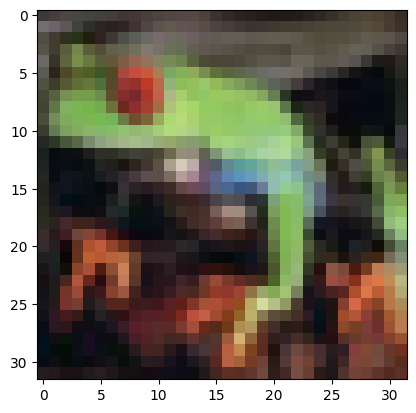

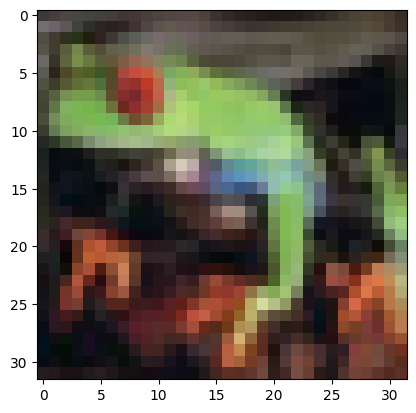

In [7]:
# Get a batch of training data
image, label = train_autoencoder_dataset[0]
# Show a single Image
imshow(image)
imshow(label)


In [8]:
import torch.nn as nn
import torch.optim as optim

# Define a simple CNN model
class SimpleCAE(nn.Module):
    def __init__(self):
        super(SimpleCAE, self).__init__()
        # Define Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 12, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(12, 16, 3, padding=1)
        )
        # Define Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(16, 12, 3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(12, 3, 3, padding=1)
        )

    def forward(self, x):
        # print(f"Received input Data with shape: {x.shape}")
        x = self.encoder(x)
        # print(f"Encoder finished and has Latent Space Representation of shape: {x.shape}")
        x = self.decoder(x)
        # print(f"Decoder finished and output has shape: {x.shape}")
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)


model = SimpleCAE().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.2)

In [ ]:
epochs = 15
loss_history = []
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    epoch_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    loss_history.append(epoch_loss / len(train_loader))
print('Finished Training')

print("Plot Loss History during Training")
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]